# Análise de Rentabilidade por Canal - Kaiserhaus
Notebook organizado para **Google Colab**.

**Objetivos:** análise de rentabilidade por canal de venda, margem líquida, ROI e custo-benefício.

**Hipótese:** "Diferentes canais de venda têm impactos distintos na margem de lucro e satisfação do cliente"


## 0. Setup (instalações e imports)
Execute esta célula apenas uma vez para instalar dependências no Colab.


In [2]:
# Se estiver no Colab, descomente a linha abaixo para garantir as dependências
# !pip install -q pandas numpy matplotlib seaborn

import os, math, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Diretório de saída para gráficos e artefatos
OUT_DIR = "out"
os.makedirs(OUT_DIR, exist_ok=True)

# Configs visuais básicas (matplotlib)
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10

print("✅ Bibliotecas importadas com sucesso!")


✅ Bibliotecas importadas com sucesso!


## 1. Carregar dados limpos
Carregamento da base de dados tratada.


In [3]:
# Caminho para o arquivo CSV limpo
caminho_csv = "../tratamento_inicial/Base_Kaiserhaus_Limpa.csv"

# Leitura do arquivo CSV
df = pd.read_csv(caminho_csv)

print("📊 Dimensão da base limpa:", df.shape)
print("📋 Colunas disponíveis:", list(df.columns))
print("\n🔍 Primeiras 5 linhas:")
df.head()


📊 Dimensão da base limpa: (5000, 16)
📋 Colunas disponíveis: ['macro_bairro', 'nome_cliente', 'bairro_destino', 'order_datetime', 'platform', 'order_mode', 'distance_km', 'tempo_preparo_minutos', 'status', 'eta_minutes_quote', 'actual_delivery_minutes', 'total_brl', 'classe_pedido', 'platform_commission_pct', 'num_itens', 'satisfacao_nivel']

🔍 Primeiras 5 linhas:


,macro_bairro,nome_cliente,bairro_destino,order_datetime,platform,order_mode,distance_km,tempo_preparo_minutos,status,eta_minutes_quote,actual_delivery_minutes,total_brl,classe_pedido,platform_commission_pct,num_itens,satisfacao_nivel
0,Outros,Júlia Ramos,Bela Vista,2024-01-01 15:08:00,rappi,delivery,6.916192,34,delivered,50,62.4,288.01,familia,0.16,8,3
1,Santo Amaro,Gustavo R. Rezende,Santo Amaro,2024-01-02 07:49:00,ifood,delivery,5.753085,16,delivered,45,35.6,125.02,combo,0.16,3,5
2,Jardins,Valentina Y. Oliveira,Jardins,2024-01-02 10:14:00,ifood,delivery,4.545672,15,delivered,43,34.5,110.76,combo,0.12,4,5
3,Vila Olímpia,Mariana Moreira,Vila Olímpia,2024-01-02 10:58:00,site_proprio,retirada,0.059679,6,delivered,19,14.4,45.16,prato_unico,0.00,1,5
4,Moema,Daniel Rocha,Ibirapuera,2024-01-02 12:56:00,site_proprio,retirada,0.102063,25,delivered,28,26.6,123.12,combo,0.00,3,5


## 2. Preparação dos dados
Criação de variáveis derivadas para análise de rentabilidade.


In [4]:
# Converter order_datetime para datetime
df['order_datetime'] = pd.to_datetime(df['order_datetime'])

# Criar variáveis derivadas para análise de rentabilidade
df['margem_liquida_brl'] = df['total_brl'] * (1 - df['platform_commission_pct'])
df['comissao_brl'] = df['total_brl'] * df['platform_commission_pct']
df['margem_percentual'] = (1 - df['platform_commission_pct']) * 100

# Variáveis temporais
df['ano'] = df['order_datetime'].dt.year
df['mes'] = df['order_datetime'].dt.month
df['dia_semana'] = df['order_datetime'].dt.day_name()
df['hora'] = df['order_datetime'].dt.hour

# Variáveis de eficiência
df['atraso_minutos'] = df['actual_delivery_minutes'] - df['eta_minutes_quote']
df['eficiencia_entrega'] = df['eta_minutes_quote'] / df['actual_delivery_minutes']

# Categorizar plataformas
df['tipo_canal'] = df['platform'].map({
    'site_proprio': 'Canal Próprio',
    'ifood': 'Marketplace',
    'rappi': 'Marketplace',
    'whatsapp': 'Canal Próprio'
})

print("✅ Variáveis derivadas criadas com sucesso!")
print("\n📊 Resumo das novas variáveis:")
print(f"• Margem líquida média: R$ {df['margem_liquida_brl'].mean():.2f}")
print(f"• Comissão média: R$ {df['comissao_brl'].mean():.2f}")
print(f"• Margem percentual média: {df['margem_percentual'].mean():.1f}%")
print(f"• Atraso médio: {df['atraso_minutos'].mean():.1f} minutos")
print(f"• Eficiência média: {df['eficiencia_entrega'].mean():.2f}")


✅ Variáveis derivadas criadas com sucesso!

📊 Resumo das novas variáveis:
• Margem líquida média: R$ 99.71
• Comissão média: R$ 10.90
• Margem percentual média: 90.2%
• Atraso médio: -7.9 minutos
• Eficiência média: inf


## 3. Análise de Margem Líquida por Plataforma
Comparação da rentabilidade entre diferentes canais de venda.


In [5]:
print("💰 ANÁLISE DE MARGEM LÍQUIDA POR PLATAFORMA")
print("=" * 60)

# Análise por plataforma
analise_plataforma = df.groupby('platform').agg({
    'total_brl': ['count', 'sum', 'mean', 'std'],
    'margem_liquida_brl': ['sum', 'mean', 'std'],
    'comissao_brl': ['sum', 'mean'],
    'platform_commission_pct': 'mean',
    'margem_percentual': 'mean',
    'satisfacao_nivel': 'mean'
}).round(2)

# Flatten das colunas
analise_plataforma.columns = ['_'.join(col).strip() for col in analise_plataforma.columns]
analise_plataforma = analise_plataforma.reset_index()

# Renomear colunas para melhor legibilidade
analise_plataforma.columns = [
    'Plataforma', 'Pedidos', 'Receita_Total', 'Ticket_Medio', 'Desvio_Ticket',
    'Margem_Liquida_Total', 'Margem_Liquida_Media', 'Desvio_Margem',
    'Comissao_Total', 'Comissao_Media', 'Comissao_Percentual_Media',
    'Margem_Percentual_Media', 'Satisfacao_Media'
]

print("\n📊 RESUMO POR PLATAFORMA:")
print(analise_plataforma.to_string(index=False))

# Calcular métricas adicionais
analise_plataforma['Participacao_Receita'] = (
    analise_plataforma['Receita_Total'] / analise_plataforma['Receita_Total'].sum() * 100
).round(1)

analise_plataforma['Participacao_Margem'] = (
    analise_plataforma['Margem_Liquida_Total'] / analise_plataforma['Margem_Liquida_Total'].sum() * 100
).round(1)

print("\n🎯 MÉTRICAS DE PARTICIPAÇÃO:")
print(analise_plataforma[['Plataforma', 'Participacao_Receita', 'Participacao_Margem']].to_string(index=False))


💰 ANÁLISE DE MARGEM LÍQUIDA POR PLATAFORMA

📊 RESUMO POR PLATAFORMA:
  Plataforma  Pedidos  Receita_Total  Ticket_Medio  Desvio_Ticket  Margem_Liquida_Total  Margem_Liquida_Media  Desvio_Margem  Comissao_Total  Comissao_Media  Comissao_Percentual_Media  Margem_Percentual_Media  Satisfacao_Media
       ifood     2661      296072.66        111.26          53.15             253250.14                 95.17          45.49        42822.52           16.09                       0.14                    85.55              4.66
       rappi      747       80978.07        108.40          52.97              69286.84                 92.75          45.22        11691.23           15.65                       0.14                    85.61              4.66
site_proprio     1052      116768.47        111.00          53.69             116768.47                111.00          53.69            0.00            0.00                       0.00                   100.00              4.90
    whatsapp      540  

/var/folders/sv/yfbh_pk51vn9y81zfv8vfnt40000gn/T/ipykernel_26565/2267872308.py:44: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/enzosmacbook/Documents/4 Semestre/InsperJr/analise-dados-insperjr-trainee/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


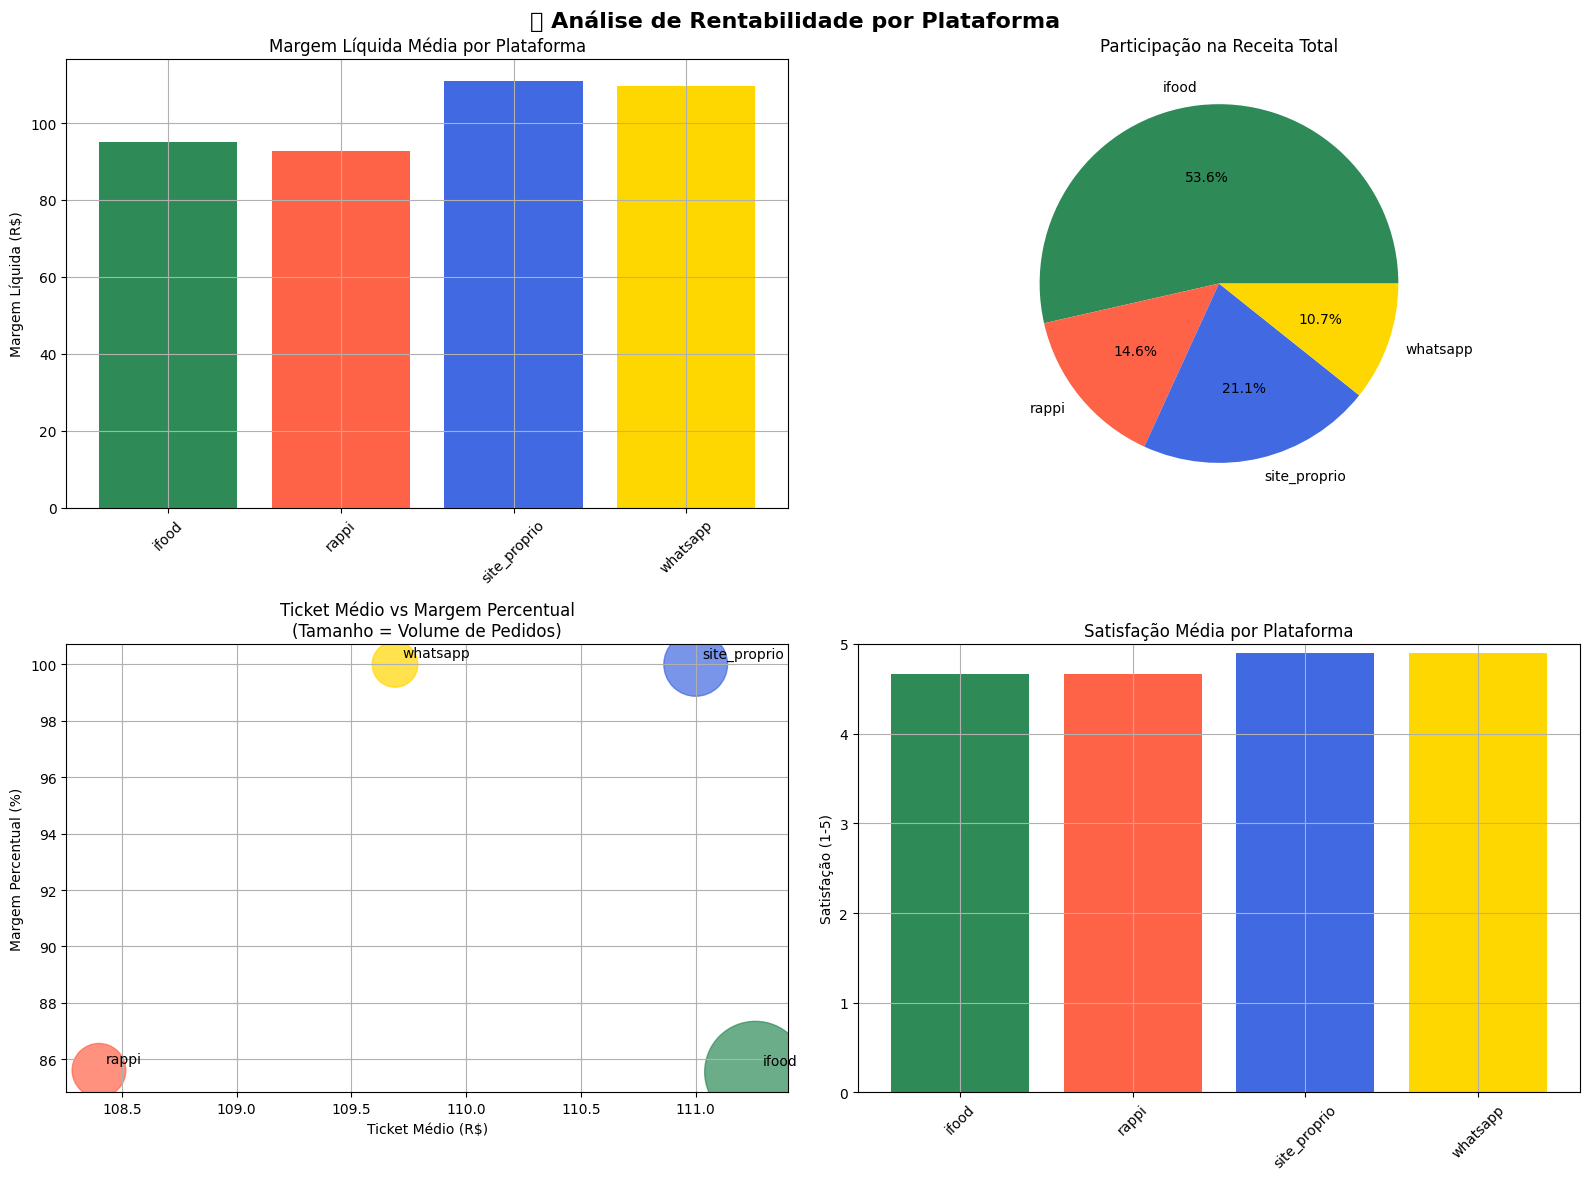

In [6]:
# Gráficos de margem líquida
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('💰 Análise de Rentabilidade por Plataforma', fontsize=16, fontweight='bold')

# 1. Margem líquida média por plataforma
axes[0,0].bar(analise_plataforma['Plataforma'], analise_plataforma['Margem_Liquida_Media'], 
               color=['#2E8B57', '#FF6347', '#4169E1', '#FFD700'])
axes[0,0].set_title('Margem Líquida Média por Plataforma')
axes[0,0].set_ylabel('Margem Líquida (R$)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Participação na receita total
axes[0,1].pie(analise_plataforma['Participacao_Receita'], 
               labels=analise_plataforma['Plataforma'],
               autopct='%1.1f%%',
               colors=['#2E8B57', '#FF6347', '#4169E1', '#FFD700'])
axes[0,1].set_title('Participação na Receita Total')

# 3. Ticket médio vs Margem percentual
scatter = axes[1,0].scatter(analise_plataforma['Ticket_Medio'], 
                           analise_plataforma['Margem_Percentual_Media'],
                           s=analise_plataforma['Pedidos']*2,
                           c=['#2E8B57', '#FF6347', '#4169E1', '#FFD700'],
                           alpha=0.7)
axes[1,0].set_xlabel('Ticket Médio (R$)')
axes[1,0].set_ylabel('Margem Percentual (%)')
axes[1,0].set_title('Ticket Médio vs Margem Percentual\n(Tamanho = Volume de Pedidos)')

# Adicionar labels aos pontos
for i, plataforma in enumerate(analise_plataforma['Plataforma']):
    axes[1,0].annotate(plataforma, 
                       (analise_plataforma['Ticket_Medio'].iloc[i], 
                        analise_plataforma['Margem_Percentual_Media'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points')

# 4. Satisfação vs Margem líquida
axes[1,1].bar(analise_plataforma['Plataforma'], analise_plataforma['Satisfacao_Media'],
               color=['#2E8B57', '#FF6347', '#4169E1', '#FFD700'])
axes[1,1].set_title('Satisfação Média por Plataforma')
axes[1,1].set_ylabel('Satisfação (1-5)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylim(0, 5)

plt.tight_layout()
plt.show()


## 4. Exel Graficos Auxiliares

In [7]:
# Slide 1 - Análise de Margens por Plataforma
analise_margens = df.groupby('platform').agg({
    'margem_liquida_brl': 'mean',
    'margem_percentual': 'mean',
    'satisfacao_nivel': 'mean',
    'total_brl': 'count'
}).round(2)

# Renomear colunas
analise_margens.columns = ['Margem_Liquida_Media', 'Margem_Percentual_Media', 'Satisfacao_Media', 'Total_Pedidos']
analise_margens = analise_margens.reset_index()

# Reordenar por margem líquida
analise_margens = analise_margens.sort_values('Margem_Liquida_Media', ascending=False)

# Salvar no Excel
analise_margens.to_excel("out/slide1_margens_plataforma.xlsx", index=False)
print("✅ Slide 1 - Dados de margens exportados!")
print(analise_margens)

✅ Slide 1 - Dados de margens exportados!
       platform  Margem_Liquida_Media  Margem_Percentual_Media  \
2  site_proprio                111.00                   100.00   
3      whatsapp                109.69                   100.00   
0         ifood                 95.17                    85.55   
1         rappi                 92.75                    85.61   

   Satisfacao_Media  Total_Pedidos  
2              4.90           1052  
3              4.90            540  
0              4.66           2661  
1              4.66            747  


In [8]:
# Slide 2 - Impacto das Comissões
analise_comissoes = df.groupby('platform').agg({
    'comissao_brl': ['sum', 'mean'],
    'total_brl': ['sum', 'mean'],
    'platform_commission_pct': 'mean'
}).round(2)

# Flatten das colunas
analise_comissoes.columns = ['Comissao_Total', 'Comissao_Media', 'Receita_Total', 'Ticket_Medio', 'Comissao_Percentual']
analise_comissoes = analise_comissoes.reset_index()

# Calcular percentual da receita que vai para comissão
analise_comissoes['Percentual_Receita_Comissao'] = (analise_comissoes['Comissao_Total'] / analise_comissoes['Receita_Total'] * 100).round(1)

# Reordenar por comissão total
analise_comissoes = analise_comissoes.sort_values('Comissao_Total', ascending=False)

# Salvar no Excel
analise_comissoes.to_excel("out/slide2_impacto_comissoes.xlsx", index=False)
print("✅ Slide 2 - Dados de comissões exportados!")
print(analise_comissoes)

✅ Slide 2 - Dados de comissões exportados!
       platform  Comissao_Total  Comissao_Media  Receita_Total  Ticket_Medio  \
0         ifood        42822.52           16.09      296072.66        111.26   
1         rappi        11691.23           15.65       80978.07        108.40   
2  site_proprio            0.00            0.00      116768.47        111.00   
3      whatsapp            0.00            0.00       59230.03        109.69   

   Comissao_Percentual  Percentual_Receita_Comissao  
0                 0.14                         14.5  
1                 0.14                         14.4  
2                 0.00                          0.0  
3                 0.00                          0.0  


In [9]:
# Slide 3 - Análise dos Canais Próprios (Site + WhatsApp)
# Criar categoria combinada
df['tipo_canal'] = df['platform'].map({
    'site_proprio': 'Canal Próprio',
    'whatsapp': 'Canal Próprio',
    'ifood': 'Marketplace',
    'rappi': 'Marketplace'
})

# Análise por tipo de canal
analise_canais = df.groupby('tipo_canal').agg({
    'total_brl': ['count', 'sum'],
    'margem_liquida_brl': ['sum', 'mean'],
    'comissao_brl': 'sum',
    'satisfacao_nivel': 'mean'
}).round(2)

# Flatten das colunas
analise_canais.columns = ['Total_Pedidos', 'Receita_Total', 'Margem_Liquida_Total', 'Margem_Liquida_Media', 'Comissao_Total', 'Satisfacao_Media']
analise_canais = analise_canais.reset_index()

# Calcular percentuais
total_pedidos = analise_canais['Total_Pedidos'].sum()
total_receita = analise_canais['Receita_Total'].sum()
total_margem = analise_canais['Margem_Liquida_Total'].sum()

analise_canais['Participacao_Pedidos_Pct'] = (analise_canais['Total_Pedidos'] / total_pedidos * 100).round(1)
analise_canais['Participacao_Receita_Pct'] = (analise_canais['Receita_Total'] / total_receita * 100).round(1)
analise_canais['Participacao_Margem_Pct'] = (analise_canais['Margem_Liquida_Total'] / total_margem * 100).round(1)

# Calcular economia potencial
analise_canais['Economia_Comissoes'] = analise_canais['Comissao_Total']
analise_canais['Economia_Potencial_Pct'] = (analise_canais['Comissao_Total'] / analise_canais['Receita_Total'] * 100).round(1)

# Salvar no Excel
analise_canais.to_excel("out/canais_proprios_combinados.xlsx", index=False)
print("✅ Slide 3 - Dados de canais próprios exportados!")
print(analise_canais)

✅ Slide 3 - Dados de canais próprios exportados!
      tipo_canal  Total_Pedidos  Receita_Total  Margem_Liquida_Total  \
0  Canal Próprio           1592      175998.50             175998.50   
1    Marketplace           3408      377050.73             322536.98   

   Margem_Liquida_Media  Comissao_Total  Satisfacao_Media  \
0                110.55            0.00              4.90   
1                 94.64        54513.75              4.66   

   Participacao_Pedidos_Pct  Participacao_Receita_Pct  \
0                      31.8                      31.8   
1                      68.2                      68.2   

   Participacao_Margem_Pct  Economia_Comissoes  Economia_Potencial_Pct  
0                     35.3                0.00                     0.0  
1                     64.7            54513.75                    14.5  
